In [1]:
import numpy as np

import westpa
from westpa.analysis import Run

import time

import pyemma
from decimal import Decimal
import matplotlib.pyplot as plt

import westpa_h5_reader_msm_functions as hmf

import weighted_msms

In [2]:
#used as an adapter between my MSM construction and pyemma's
class msm():
    def __init__(self, eqp, sio):
        self.stationary_distribution = eqp
        self.active_set = sio

loaded data for 501 WE rounds in 62.79921340942383 seconds
identified 86180 transitions in 0.009286642074584961 seconds
eigenvector converged to within 10^-12 after 0 rounds
built MSM in 0.3144073486328125 seconds
loaded data for 501 WE rounds in 61.8202748298645 seconds
identified 87396 transitions in 0.005366802215576172 seconds
eigenvector converged to within 10^-12 after 0 rounds
built MSM in 0.2126166820526123 seconds
loaded data for 501 WE rounds in 40.589980602264404 seconds
identified 55396 transitions in 0.002797365188598633 seconds
eigenvector converged to within 10^-12 after 0 rounds
built MSM in 0.14163565635681152 seconds
loaded data for 501 WE rounds in 70.89500999450684 seconds
identified 98752 transitions in 0.004741668701171875 seconds
eigenvector converged to within 10^-12 after 0 rounds
built MSM in 0.28339147567749023 seconds


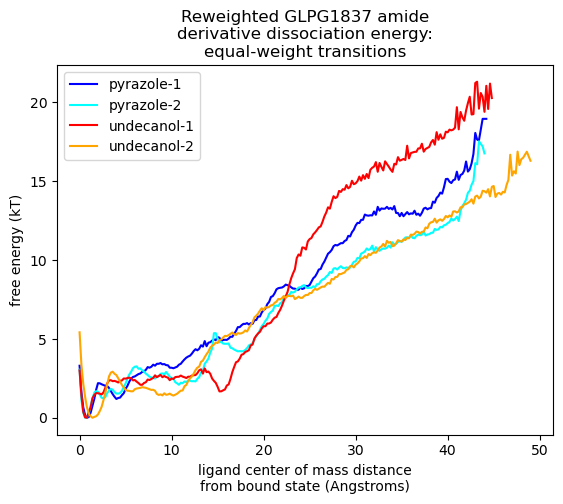

In [3]:
#miniter = 0
#maxiter = 2000 #make a variable
#rmax = maxiter

use_pyemma=False
weighted=False

cftr_west = "/home/jonathan/Documents/grabelab/cftr/chloe-data"
cftr_refpc = "/home/jonathan/Documents/grabelab/cftr/refeaturization"


if weighted:
    savefigname = f"glpg_reweighted_dissociation_energy_WE_weighted_transitions"
else:
    savefigname = f"glpg_reweighted_dissociation_energy_unweighted_transitions"
    

#can we make this read in the bounds from a west.cfg file?
h5paths_names = [ [f"{cftr_west}/wstp_cftr_1_degrabo/west-040925.h5", f"{cftr_refpc}/nonlip_glpg_1", "pyrazole-1",  "blue",   1500, 2001, [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  [f"{cftr_west}/wstp_cftr_2_wynton/west-040925.h5",  f"{cftr_refpc}/nonlip_glpg_2", "pyrazole-2",  "cyan",   500, 1001, [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  [f"{cftr_west}/wstp_lip_glpg_1/west-040925.h5",     f"{cftr_refpc}/lip_glpg_1",    "undecanol-1", "red",    1500, 2001, [0, 1, 3, 5, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  [f"{cftr_west}/wstp_lip_glpg_2/west-040925.h5",     f"{cftr_refpc}/lip_glpg_2",    "undecanol-2", "orange", 1500, 2001, [0,1,1.3,1.5,1.7,2,2.2,2.4,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,25.5,26,26.5,27,28,29,30,32,34,36,38,40,41,50]]
]

uniform_we_bins = np.arange(0,50,0.2)

legend=[]

for h5pn in h5paths_names:
    h5path = h5pn[0]
    binbounds = uniform_we_bins #h5pn[4]
    
    #binning along continuous PC
    
    pclims = [binbounds[0], binbounds[-1]]
    nb = len(binbounds)+1
    
    #discrete PC
    n_discrete_pc_vals = 1
    
    #bound state edge
    threshold = 0
    
    t1 = time.time()
    pcs, parent_pcs, weights, pc_init, maxiter = hmf.h5_2_pcs(h5path, h5pn[4], h5pn[5])
    #print(pcs)
    #print("----------------------------------------------------------------------------------------------------------")
    #print(parent_pcs)
    t2 = time.time()
    print(f"loaded data for {len(pcs)} WE rounds in {t2-t1} seconds")

    rmax=h5pn[5]
    #for rmax in range(200,maxiter,200):
    
    t3 = time.time()
    transitions = hmf.pcs_2_transitions(np.concatenate(pcs[:rmax]), np.concatenate(parent_pcs[:rmax]), binbounds, n_discrete_pc_vals)
    t4 = time.time()
    print(f"identified {len(transitions)} transitions in {t4-t3} seconds")

    #print(transitions)
    
    t5 = time.time()
    
    if use_pyemma:
        #consider using deeptime instead, or https://moldyn.github.io/msmhelper/ which is supposedly faster
        pyem = pyemma.msm.bayesian_markov_model(list(transitions), lag=1, reversible=True)
    elif weighted:
        tpm, sio = weighted_msms.transitions_2_msm(transitions, np.concatenate(weights[:rmax]))
        eqp = weighted_msms.tpm_2_eqprobs(tpm)
        pyem = msm(eqp.transpose()[0], sio)
    else:
        tpm, sio = weighted_msms.transitions_2_msm(transitions, np.ones(transitions.shape[0]))
        eqp = weighted_msms.tpm_2_eqprobs(tpm)
        pyem = msm(eqp.transpose()[0], sio)
    
    t6 = time.time()
    print(f"built MSM in {t6-t5} seconds")
    
    # plot MSM energies
    q_below_total, bin_x_all, energies = hmf.plot_2d_pc_webins(pyem, nb, binbounds, pclims, n_discrete_pc_vals, pc_init[0], threshold, plottitle=savefigname)

    plt.plot(bin_x_all[0], energies[0], color=h5pn[3])
    legend.append(h5pn[2])
    
    #plt.show()
    
plt.legend(legend)

if weighted:
    plt.title("Reweighted GLPG1837 amide\nderivative dissociation energy:\nWE-weighted transitions")
    #savefigname = f"glpg_reweighted_dissociation_energy_WE_weighted_transitions"
else:
    plt.title("Reweighted GLPG1837 amide\nderivative dissociation energy:\nequal-weight transitions")
    #savefigname = f"glpg_reweighted_dissociation_energy_unweighted_transitions"
    
plt.xlabel("ligand center of mass distance\nfrom bound state (Angstroms)")
plt.ylabel("free energy (kT)")

#plt.xlim(0,5)

plt.savefig(savefigname+".svg", dpi=600, format="svg", bbox_inches="tight")


In [ ]:
#print(len(pyem.stationary_distribution))
#print(len(pyem.active_set))

In [ ]:
#len(pyem.stationary_distribution[0])

In [ ]:
# import os
# print(os.getcwd())

In [ ]:
#pcs

In [ ]:
a = [1,2,3]

In [ ]:
a

In [ ]:
a[:3]